In [2]:
from pathlib import Path

from llama_index.core import VectorStoreIndex, load_index_from_storage
from llama_index.core.storage import StorageContext
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.core import Settings

# Use this so don't need to bother with API key to default OPENAI model
Settings.embed_model = HuggingFaceEmbedding(
    model_name="BAAI/bge-small-en-v1.5", device="cpu"  # Use "cuda" for GPU acceleration
)

# Define the directory where the index is stored
persist_dir = "./storage"  # Change this to your actual storage directory

# Load the index from storage
storage_context = StorageContext.from_defaults(persist_dir=persist_dir)
index = load_index_from_storage(storage_context)
retriever = index.as_retriever()
nodes = list(index.docstore.docs.values())

In [3]:
len(nodes)

2968

In [4]:
# Extract embeddings & data
import numpy as np
import pandas as pd

# Extract embeddings and metadata
data = []
for node in nodes:
    metadata = node.metadata  # Extract metadata
    data.append({
        "note_id": node.id_,
        "note_title": metadata.get("file_name", "Unknown").replace(".md", ""),
        "folder": metadata.get("folder_name", "Uncategorized"),
        "links": metadata.get("wikilinks", []),  # Store internal links
        "backlinks": metadata.get("backlinks", []),  # Store backlinks
        "embedding": index._vector_store._data.embedding_dict[node.id_]
    })

# Convert to DataFrame
df = pd.DataFrame(data)

# Convert embeddings into a NumPy array for clustering
embeddings = np.vstack(df["embedding"].values)


In [5]:
df.head()

,note_id,note_title,folder,links,backlinks,embedding
0,dfa280e0-5f55-412e-b2f4-2a432835d714,"Home - Priorities, Next, Index",.,"[0 - Tasks this Week, AMOC - Meta - Obsidian -...","[AMOC - Priorities, Vision, Long Term, WK - 25...","[-0.01763683557510376, 0.007754608057439327, 0..."
1,06203e5a-6c30-4e41-81e5-6e897f027889,"Home - Priorities, Next, Index",.,"[MOC Journal - State of Union - Ruvi, Homework...","[AMOC - Priorities, Vision, Long Term, WK - 25...","[-0.01486171130090952, 0.01706085354089737, -0..."
2,39591306-197b-430d-9d80-902764ab8a64,"Home - Priorities, Next, Index",.,"[AMOC - Finances, AMOC - Self - Mental, AMOC -...","[AMOC - Priorities, Vision, Long Term, WK - 25...","[-0.016235508024692535, 0.01410036999732256, -..."
3,1168cd8e-d311-4b09-beb7-93414aec5497,"Home - Priorities, Next, Index",.,"[Ideas - Someday Maybe List, Ideas - Content a...","[AMOC - Priorities, Vision, Long Term, WK - 25...","[-0.013082915917038918, 0.02079198881983757, -..."
4,136c218f-f1c0-4e96-9267-91c41c3206c6,Time series RAG,0-Inbox,[AMOC - Trading],"[2025-02-01 - AI for distillation, for search,...","[-0.026576388627290726, -0.00799475982785225, ..."


In [21]:
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
from sklearn.preprocessing import normalize

# Stack embeddings into a matrix (shape: [num_notes, embedding_dimension])
embeddings_matrix = normalize(np.stack(df['embedding'].values), axis=1)

# Compute cosine similarity between all pairs of notes
similarity_matrix = cosine_similarity(embeddings_matrix)


In [22]:
similarity_matrix.shape

(2968, 2968)

In [63]:
# ------------------------------
# 2. Group Notes into Clusters Based on Similarity
# ------------------------------

# Build an undirected graph where each node is a note_id.
G = nx.Graph()
for note_id in df['note_id']:
    G.add_node(note_id)

# Set a similarity threshold: notes with similarity above this value will be connected.
similarity_threshold = 0.98  # Adjust as needed based on your embeddings

# Add edges between notes that exceed the similarity threshold.
num_notes = len(df)
for i in range(num_notes):
    for j in range(i + 1, num_notes):
        if similarity_matrix[i, j] > similarity_threshold:
            note_i = df.iloc[i]['note_id']
            note_j = df.iloc[j]['note_id']
            G.add_edge(note_i, note_j)

# Extract connected components from the graph. Each component is a natural cluster.
clusters = list(nx.connected_components(G))
print(f"Found {len(clusters)} clusters.")

Found 2657 clusters.


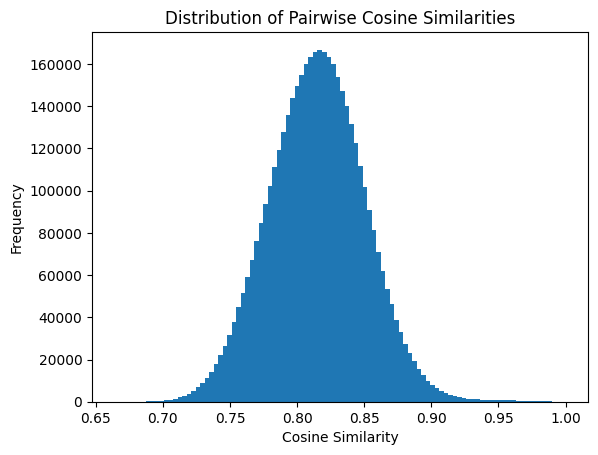

In [33]:
import matplotlib.pyplot as plt

# Get the upper triangular part of the similarity matrix, excluding the diagonal.
sim_scores = similarity_matrix[np.triu_indices(num_notes, k=1)]
plt.hist(sim_scores, bins=100)
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.title('Distribution of Pairwise Cosine Similarities')
plt.show()


In [64]:
G.number_of_edges()

598

In [44]:
len(G._node)

2968

In [66]:
# ------------------------------
# 3. Identify and Select the Top 20 Largest Clusters
# ------------------------------

# Sort clusters by the number of notes in descending order.
clusters_sorted = sorted(clusters, key=lambda cluster: len(cluster), reverse=True)

# Select the top 20 clusters (or fewer if there aren't 20 clusters).
top_clusters = clusters_sorted[:50]
print("Top clusters (by note IDs):")
for idx, cluster in enumerate(top_clusters, 1):
    print(f"Cluster {idx}: {len(cluster)}")

Top clusters (by note IDs):
Cluster 1: 32
Cluster 2: 11
Cluster 3: 10
Cluster 4: 9
Cluster 5: 8
Cluster 6: 8
Cluster 7: 8
Cluster 8: 7
Cluster 9: 6
Cluster 10: 6
Cluster 11: 6
Cluster 12: 6
Cluster 13: 6
Cluster 14: 5
Cluster 15: 5
Cluster 16: 5
Cluster 17: 5
Cluster 18: 5
Cluster 19: 5
Cluster 20: 4
Cluster 21: 4
Cluster 22: 4
Cluster 23: 4
Cluster 24: 4
Cluster 25: 4
Cluster 26: 4
Cluster 27: 4
Cluster 28: 4
Cluster 29: 4
Cluster 30: 4
Cluster 31: 4
Cluster 32: 4
Cluster 33: 3
Cluster 34: 3
Cluster 35: 3
Cluster 36: 3
Cluster 37: 3
Cluster 38: 3
Cluster 39: 3
Cluster 40: 3
Cluster 41: 3
Cluster 42: 3
Cluster 43: 3
Cluster 44: 3
Cluster 45: 3
Cluster 46: 3
Cluster 47: 3
Cluster 48: 3
Cluster 49: 3
Cluster 50: 3


In [50]:
top_clusters[0]

{'00f59712-2929-4830-9a22-0c88c0b6aef5',
 '094c69b9-19df-479b-9653-aa78ce15bcaa',
 '09fa975b-8c35-4bdc-b3aa-aa2531bd1645',
 '0ae333ca-632a-4122-9d6b-12051957127f',
 '0c14f889-d8af-41a7-98d7-47f45c68f43a',
 '103377bf-2af4-49b2-8dd8-523f361cdd84',
 '16eda8fe-c218-42b2-9e8d-4b5f790becf2',
 '26dda743-2a8a-4975-9d81-f7bca8f130c8',
 '28d90a7e-967d-4b0a-a7f0-9374f0ecf984',
 '3291905b-8fca-49b6-b203-4bbcfc95f4a7',
 '3396c77d-4baa-40f3-bf84-4a0cce053476',
 '383df587-dbb6-4697-9200-cd4a3890d843',
 '3c8e5fa7-9ed1-4b07-8c2c-b18bedc5d918',
 '3d3fde44-f444-4681-87df-da14de2264cc',
 '4e2bfce0-9ecb-475d-a69b-934366e85b83',
 '50b932e2-5d50-46b2-8801-1c1191a1cce6',
 '5a3b9cf0-338c-4260-9d4d-35dbca007bff',
 '5a8ec2fd-fc1f-44f9-a457-c35c9dc297fe',
 '5b8a8efe-393a-4ed2-8e70-3947408a4634',
 '6025ec6a-daab-4b72-82e3-741b8d5f3b02',
 '63c04668-fede-4b95-968b-1cc1e8426d0b',
 '69b5a5aa-3740-4155-9c35-f0881aa07d88',
 '6ad493cc-1066-4db5-a26f-8574062eaa8c',
 '6d3f79fe-e5bd-43b1-aaaf-848ee1be6eb1',
 '70744104-a4c9-

In [67]:
node_map = {node.node_id: node for node in nodes}

In [68]:
# Prepare the clusters for QA generation by collecting note information.
cluster_data = []
for cluster in top_clusters:
    combined_text = ""
    for node_id in cluster:
        document = node_map[node_id]
        combined_text += document.text
    cluster_data.append({
        "cluster_id": cluster,
        "combined_text": combined_text
    })


In [69]:
len(cluster_data[0]['combined_text'])

11977

In [ ]:
# ------------------------------
# 4. (Conceptual) Second Round of QA Generation Using Backlinks
# ------------------------------

# For the second round, you might want to enrich the QA context by combining
# the notes’ content with content from notes that are referenced in their backlinks.
# The following pseudocode outlines how you could do this:

for cluster in top_clusters:
    # Start with an empty context for the cluster.
    enriched_context = []
    
    # Get all notes in the current cluster.
    cluster_notes = df[df['note_id'].isin(cluster)]
    
    for _, note in cluster_notes.iterrows():
        # Add primary note content (here using the title as a placeholder).
        enriched_context.append(f"Primary Note: {note['note_title']}")
        
        # Check if the note has any backlinks.
        # We assume `backlinks` is a list of note_ids that link to this note.
        if note['backlinks']:
            # Retrieve the backlink notes from the DataFrame.
            backlink_notes = df[df['note_id'].isin(note['backlinks'])]
            for _, backlink_note in backlink_notes.iterrows():
                # Add backlink note content to the enriched context.
                enriched_context.append(f"Backlink Note: {backlink_note['note_title']}")
    
    # Combine the enriched context into a single prompt.
    prompt = "\n".join(enriched_context)
    print(f"\nEnriched QA prompt for cluster (IDs {cluster}):\n{prompt}")

# Prompt for QA Pairs

In [72]:
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv("/Users/chris/repos/deep-learning/keys.env")

True

In [73]:
from llama_index.llms.openai import OpenAI

llm = OpenAI(model="gpt-4o-mini", temperature=0.7, max_tokens=2044)

In [98]:
len(cluster_data)

50

In [99]:
import json

responses = []
for cluster in cluster_data:
    cluster_id = cluster["cluster_id"]
    combined_text = cluster["combined_text"]
    
    # Build a custom prompt: instruct the model to generate, say, 5 QA pairs
    prompt = (
        "You are an expert knowledge curator and teacher. Below is a text passage that represents a collection of personal notes, ideas, and reflections from a second brain. "
        "Your task is to distill the core concepts, connections, and insights from the text and generate 5 diverse, high-quality question–answer pairs that a curious student might ask. "
        "Ensure that the questions probe important ideas, and the answers are concise, clear, and directly based on the text. "
        "Distill the core ideas from the text, and look for connections between the notes. "
        "Ignore things like tasks and focus on core ideas, unique concepts, and connections between them. "
        "Please output your answer as valid JSON in the following format:\n\n"
        '[{{"question": "<your question>", "answer": "<the answer>"}}, ...]\n\n'
        "Text:\n'''{}'''".format(combined_text)
    )

    response = llm.complete(prompt)
    responses.append({"cluster_id": cluster_id, "response": response})

In [100]:
qa_dataset = []
for response_pair in responses:
    try:
        qa_pairs = json.loads(response_pair["response"].text.replace("```json", "").replace("```", ""))
    except Exception as e:
        # If JSON parsing fails, you might log the error and skip or try to clean the output.
        print(f"Error parsing JSON for cluster {response_pair['cluster_id']}: {e}")
        qa_pairs = []  # Or apply regex/post-processing as needed
    
    # Store the result along with the cluster ID
    qa_dataset.append({
        "cluster_id": response_pair["cluster_id"],
        "qa_pairs": qa_pairs
    })

In [106]:
qa_dataset[0]['qa_pairs']

[{'question': "What is the primary focus of the author's niche as a content creator?",
  'answer': "The author's primary focus is as a Data Engineer specializing in AI, particularly in deep learning for time series data, while also exploring augmented learning and sharing insights through podcasts and YouTube."},
 {'question': 'How does the author intend to balance their professional ambitions with personal life?',
  'answer': "The author aims to balance professional ambitions with personal life by optimizing for 'Joyspan', which emphasizes achieving fulfillment and happiness alongside work success and family life."},
 {'question': "What is the significance of the term 'Augmented Engineer' in the author's work?",
  'answer': "'Augmented Engineer' signifies the author's approach to using AI to enhance learning and productivity while maintaining a focus on human values and balance in life, integrating technical skills with soft skills and personal stories."},
 {'question': 'Why does the 

In [111]:
alpaca_formatted = []  # This list will hold the Alpaca-style entries.

# Iterate over each cluster in qa_dataset.
for cluster in qa_dataset:
    cluster_id = cluster.get("cluster_id")  # Optional: used if you want to track cluster source.
    qa_pairs = cluster.get("qa_pairs", [])
    
    # Iterate over each question-answer pair.
    for qa in qa_pairs:
        # Extract question and answer; strip extra whitespace if any.
        question = qa.get("question", "").strip()
        answer = qa.get("answer", "").strip()
        
        # Create the Alpaca-style dictionary.
        alpaca_entry = {
            "instruction": question,
            "input": "",       # You can add additional context here if needed.
            "output": answer,
            "cluster_id": cluster_id  # Optional: include cluster id for traceability.
        }
        
        # Append the entry to the final list.
        alpaca_formatted.append(alpaca_entry)

In [115]:
class SetEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, set):
            return list(obj)
        return super().default(obj)
    
json_output = json.dumps(alpaca_formatted, ensure_ascii=False, indent=2, cls=SetEncoder)

print(json_output)

[
  {
    "instruction": "What is the primary focus of the author's niche as a content creator?",
    "input": "",
    "output": "The author's primary focus is as a Data Engineer specializing in AI, particularly in deep learning for time series data, while also exploring augmented learning and sharing insights through podcasts and YouTube.",
    "cluster_id": [
      "63c04668-fede-4b95-968b-1cc1e8426d0b",
      "9b5dcbdd-45fa-4c35-a2fe-f3c7f78343f6",
      "9dafe420-6131-4e3e-b823-0f1d040c0a05",
      "b382c344-3e97-43c1-8ea5-b1c1307b7719",
      "69b5a5aa-3740-4155-9c35-f0881aa07d88",
      "50b932e2-5d50-46b2-8801-1c1191a1cce6",
      "28d90a7e-967d-4b0a-a7f0-9374f0ecf984",
      "8b34805b-3993-4f98-8309-d55ed132496c",
      "3396c77d-4baa-40f3-bf84-4a0cce053476",
      "00f59712-2929-4830-9a22-0c88c0b6aef5",
      "3c8e5fa7-9ed1-4b07-8c2c-b18bedc5d918",
      "a28c3d88-9636-4f96-b5fa-196a3f115ec1",
      "b1fe2966-6d18-45a1-b5bd-02325efa256b",
      "3291905b-8fca-49b6-b203-4bbcfc9

In [116]:
output_filename = "alpaca_finetune_dataset.json"

# Write to a file
with open(output_filename, "w", encoding="utf-8") as f:
    json.dump(alpaca_formatted, f, ensure_ascii=False, indent=2, cls=SetEncoder)

print(f"Alpaca-style dataset with {len(alpaca_formatted)} entries saved to '{output_filename}'.")

Alpaca-style dataset with 250 entries saved to 'alpaca_finetune_dataset.json'.
